In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Generate synthetic data
np.random.seed(123)
n_groups = 5
n_per_group = 10

# True parameters
true_mu = 3.0
true_sigma = 2.0

# Group-level parameters
group_mu = np.random.normal(true_mu, true_sigma, n_groups)
group_sigma = np.random.uniform(0.5, 1.5, n_groups)

# Observationss
data = [np.random.normal(group_mu[i], group_sigma[i], n_per_group) for i in range(n_groups)]

In [3]:
group_mu

array([ 0.82873879,  4.99469089,  3.565957  , -0.01258943,  1.8427995 ])

In [4]:
data

[array([ 3.27412689,  0.16618459,  3.29924817,  0.61643797, -0.08813692,
        -0.31061074,  1.68276365,  1.01609385, -1.09845948,  4.09741831]),
 array([5.61405172, 5.54640065, 5.85359201, 6.76699064, 5.87926178,
        3.69021082, 3.32372409, 4.10885138, 3.82779047, 4.10776446]),
 array([3.80174092, 1.74570301, 1.82043301, 0.86817428, 3.33626438,
        2.88324686, 1.8256523 , 5.88252701, 3.60028283, 3.22788697]),
 array([-6.59403437e-01,  9.14861449e-01, -2.28239249e-01, -1.13314274e-01,
        -1.49412523e+00, -5.11450985e-04,  2.88387937e-01, -8.39246018e-01,
         2.33409664e-01,  3.18254429e-01]),
 array([2.83294946, 0.12921515, 2.33395768, 1.23471992, 0.40735334,
        2.49005791, 2.15534792, 3.5927812 , 1.95052197, 3.36042671])]

In [5]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Priors for each group
    group_mu = pm.Normal('group_mu', mu=mu, sigma=sigma, shape=n_groups)
    group_sigma = pm.HalfNormal('group_sigma', sigma=10, shape=n_groups)
    
    # Likelihood for each observation
    obs = []
    for i in range(n_groups):
        obs.append(pm.Normal(f'obs_{i}', mu=group_mu[i], sigma=group_sigma[i], observed=data[i]))
    
    # Sample from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, group_mu, group_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


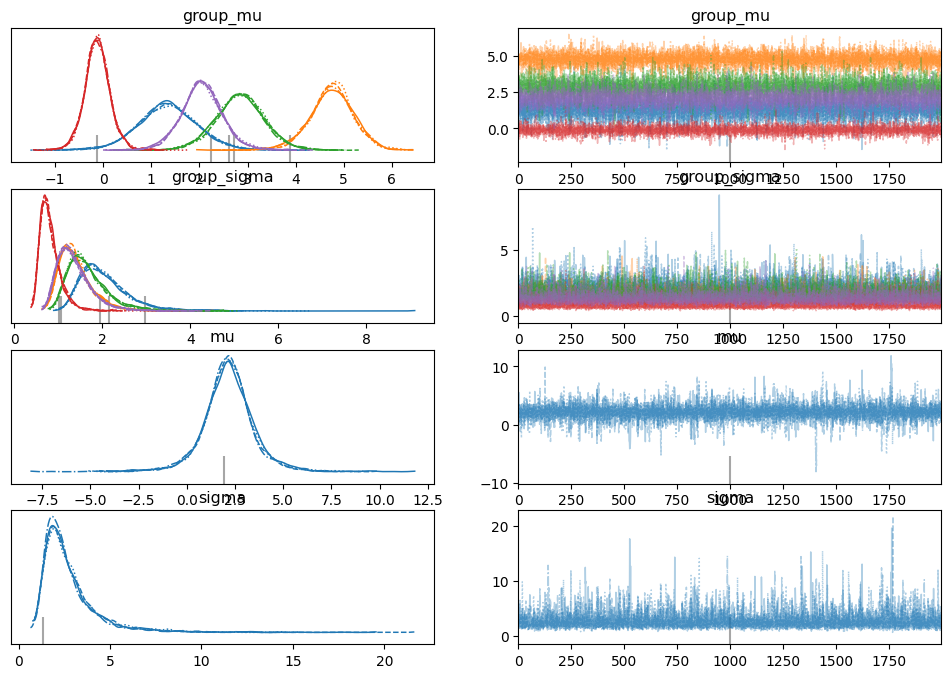

In [6]:
# Summary of the trace
az.summary(trace, hdi_prob=0.95)

# Trace plot
az.plot_trace(trace)
plt.show()



In [7]:
# Posterior predictive checks
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["obs_0", "obs_1", "obs_2", "obs_3", "obs_4"])

Sampling: [obs_0, obs_1, obs_2, obs_3, obs_4]


Output()

In [8]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

# Group dependent coefficients

In [2]:
np.random.seed(123)

# Parameters
n_groups = 5
n_per_group = 20
income_mean = 50000
income_std = 10000

# True group-level parameters
true_constant = 100
true_beta = np.random.normal(0, 0.1, n_groups)  # Different slope for each group

# Generate data
incomes = np.random.normal(income_mean, income_std, (n_groups, n_per_group))
iq = np.zeros((n_groups, n_per_group))

for g in range(n_groups):
    iq[g] = true_constant + true_beta[g] * incomes[g] + np.random.normal(0, 15, n_per_group)

# Flatten the data for modelings
incomes = incomes.flatten()
iq = iq.flatten()
groups = np.repeat(np.arange(n_groups), n_per_group)

In [8]:
sorted(true_beta)

[-0.1506294713918092,
 -0.10856306033005612,
 -0.05786002519685364,
 0.028297849805199206,
 0.09973454465835858]

In [4]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for the intercept and slope
    constant = pm.Normal('constant', mu=100, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=0.1, shape=n_groups)
    
    # Group-specific means
    mu = constant + beta[groups] * incomes
    
    # Likelihood
    sigma = 15 # pm.Constant('sigma', 15)  # Fixed standard deviation
    iq_obs = pm.Normal('iq_obs', mu=mu, sigma=sigma, observed=iq)
    
    # Sample from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [constant, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


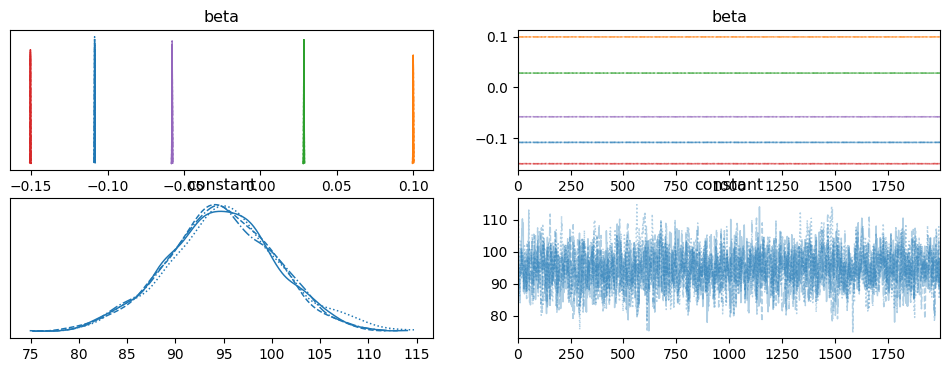

Sampling: [iq_obs]


Output()

In [6]:
# Summary of the trace
az.summary(trace, hdi_prob=0.95)

# Trace plot
az.plot_trace(trace)
plt.show()

# Posterior predictive checks
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["iq_obs"])

# New model

In [9]:
np.random.seed(123)

# Parameters
n_groups = 5
n_per_group = 20
income_mean = 50000
income_std = 10000

# True group-level parameters
true_constant = np.random.normal(0, 1, n_groups)
true_beta = np.random.normal(0, 0.01, n_groups)  # Different slope for each group

# Generate data
incomes = np.random.normal(income_mean, income_std, (n_groups, n_per_group))
iq = np.zeros((n_groups, n_per_group))

for g in range(n_groups):
    sigma = np.exp(true_constant[g] + true_beta[g] * incomes[g])
    iq[g] = 100 + np.random.normal(0, sigma, n_per_group)

# Flatten the data for modeling
incomes = incomes.flatten()
iq = iq.flatten()
groups = np.repeat(np.arange(n_groups), n_per_group)

/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000gn/T/ipykernel_1155/3680141509.py:18: RuntimeWarning: overflow encountered in exp
  sigma = np.exp(true_constant[g] + true_beta[g] * incomes[g])


In [10]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for the intercept and slope
    constant = pm.Normal('constant', mu=0, sigma=1, shape=n_groups)
    beta = pm.Normal('beta', mu=0, sigma=0.01, shape=n_groups)
    
    # Group-specific standard deviations
    sigma = pm.Deterministic('sigma', pm.math.exp(constant[groups] + beta[groups] * incomes))
    
    # Likelihood
    iq_obs = pm.Normal('iq_obs', mu=100, sigma=sigma, observed=iq)
    
    # Sample from the posterior
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'constant': array([ 0.84957889,  0.51033521,  0.00839195, -0.76056148,  0.4231092 ]), 'beta': array([-0.62130741,  0.63652791, -0.25949458, -0.26242639, -0.91343985])}

Logp initial evaluation results:
{'constant': -5.46, 'beta': -8790.41, 'iq_obs': -inf}
You can call `model.debug()` for more details.